House data prediction project

We start with all the imports needed

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from threading import Thread
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


Scraper:

The first part of the scraper collects all the advertisments found on a particular site and saves them in a link format

In [ ]:
driver = webdriver.Chrome(keep_alive=True)

options = Options()
options.add_argument('--incognito')

driver.get("https://www.storia.ro/ro/rezultate/vanzare/casa/bucuresti?limit=36&ownerTypeSingleSelect=ALL&by=DEFAULT&direction=DESC&viewType=listing")

def acceptCookies():
    button = driver.find_element(By.ID, "onetrust-accept-btn-handler")
    button.click()

def getLinks():    
    list = []
    nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
    houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
    while(nextPageButton.is_enabled()):
        houses = houseList.find_elements(By.XPATH, "//a[@data-cy='listing-item-link']")
        for house in houses:
            link = house.get_attribute("href")
            list.append(link)
        nextPageButton.click()
        houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
        if(driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']").is_displayed()):
            nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
        
    df = pd.DataFrame(list)
    df.to_csv(r"..\CSVs\HouseLinks.csv")

    display(df)

acceptCookies()
getLinks()

driver.close()

The next part opens the links using threads and collects the necessary information for each house

In [ ]:
df = pd.read_csv(r"..\CSVs\HouseLinks.csv")
linkList = df.values.tolist()

HouseDataList = []
 
def openDriver():

    options = Options()
    options.add_argument('--incognito')
    driver = webdriver.Chrome(keep_alive=True, options=options)

    return driver

def scrapeData(link, driver):

    driver.get(link)
    ok = 1
    try:
        table = driver.find_element(By.XPATH, "//div[@data-testid='ad.top-information.table']")
        tableKeys = table.find_elements(By.XPATH, "//div[contains(@data-cy, 'table-label')]")
        tableValues = table.find_elements(By.XPATH, "//div[contains(@data-testid, 'table-value')] | //button[@data-cy='missing-info-button']")

    except Exception as error:
        print(error)
        ok = 0


    if ok == 1:
        houseDetails = {}

        keys = []
        values = []

        for key in tableKeys:
            keys.append(key.get_attribute("innerText"))
        for value in tableValues:
            values.append(value.get_attribute("innerText"))

        for key in keys:
            for value in values:
                houseDetails[key] = value
                values.remove(value)
                break

        price = driver.find_element(By.XPATH, "//strong[@data-cy='adPageHeaderPrice']")

        houseDetails["Pret"] = price.get_attribute("innerText")

        HouseDataList.append(houseDetails)

def threadWork(linkList, start, noLinks):

    driver = openDriver()

    for i in range(start, noLinks):
        scrapeData(linkList[i][1], driver)

    driver.close()

def openDriverWithThreads(linkList: list):

    size = len(linkList)
    size /= 10
    size = int(size)

    limits = []


    for i in range(0, 10):
        limits.append(size * i)

    limits.append(len(linkList) - 1)

    threads = [Thread(target=threadWork, args=(linkList, limits[i - 1], limits[i])) for i in range(1, 11)]

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()
        

openDriverWithThreads(linkList)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

DataSet = pd.DataFrame(HouseDataList)

display(DataSet)

DataSet.to_csv(r"..\CSVs\UneditedDataSet--tab-separated.csv", encoding="utf-16", sep='\t')
DataSet.to_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16")


The last part takes care of preparing the collected data, making it suitable for data manipulation and machine learning

In [4]:
df = pd.read_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16", index_col=0)

def replaceCategoriesWithNumbers():
    categoryDict = {}

    for column in df:
        if(not df[column].astype(str).str.contains(r'\d', na=False).any()):
            columnCategories = pd.Categorical(df[column])

            columnDict = {}
        
            for index, category in enumerate(columnCategories.categories):
                columnDict[category] = index + 1

            categoryDict[column] = columnDict

    for column in categoryDict:
        for label in categoryDict[column]:
            df[column] = df[column].replace(label, categoryDict[column][label])


    print(categoryDict)

df["Informații suplimentare"] = df["Informații suplimentare"].map(lambda x: 1 if isinstance(x, str) and "aer condiționat" in x else 0)
df["Tip mansardă"] = df["Tip mansardă"].map(lambda x: x if isinstance(x, str) and ("utilizabilă" in x or "neutilizabilă" in x) else pd.NA)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 1 if isinstance(x, str) and "un nivel" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 2 if isinstance(x, str) and "2 etaje" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: "3" if isinstance(x, str) and "3 sau mai multe" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: pd.NA if isinstance(x, str) and "da" in x else x)

df = df.rename(columns={"Informații suplimentare": "Aer condiționat"})
df = df.drop(["Vizionare la distanță", "Chirie", "Tip vânzător", "Liber de la", "Casa de vacanta", "Media", "Siguranță", "Imprejurimi", "Tip gard", "Tip geamuri"], axis= 1)
df = df.replace(['Cere informații', 'fără informații'], pd.NA)
df["Numărul de camere"] = df["Numărul de camere"].replace("mai mult de 10", '10')

df = df.map(lambda x: x.replace(" m²", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" €", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" RON", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(".", "-") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(",", ".") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace("-", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

replaceCategoriesWithNumbers()

df = df.map(lambda x: float(x) if isinstance(x, str) else x)

df = df.replace(pd.NA, 0)

display(df)
display(df.describe())

df.to_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16")
df.to_csv(r"..\CSVs\EditedDataSet--tab-separated.csv", encoding="utf-16", sep="\t")


AttributeError: 'DataFrame' object has no attribute 'map'

Machine Learning Algorithm:

In [49]:
df = pd.read_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16", index_col=0)

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10

fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size

sns.set_theme()

<Axes: xlabel='Pret', ylabel='Count'>

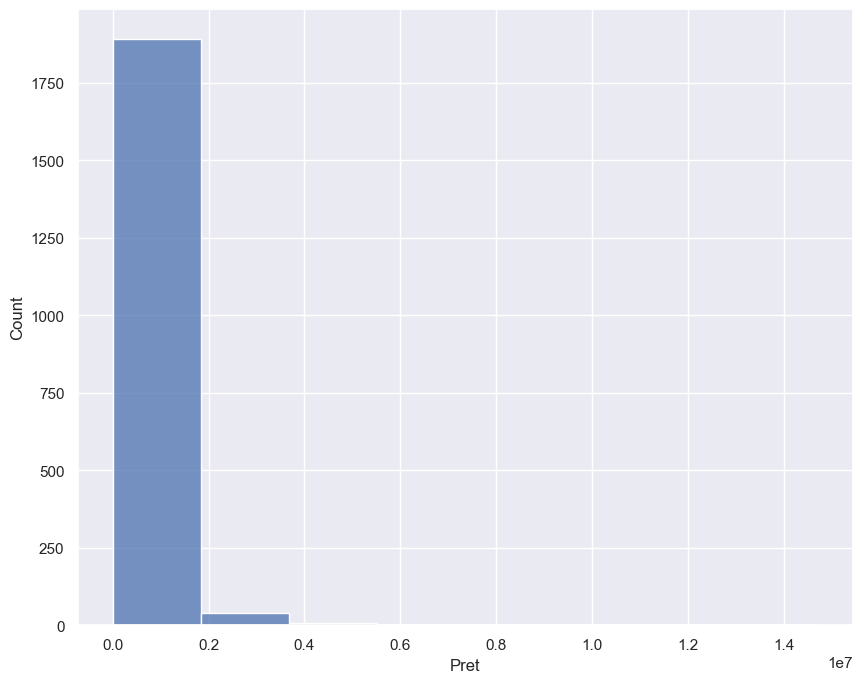

In [104]:
sns.histplot(df['Pret'], kde=False, bins=8)

<Axes: xlabel='Suprafață', ylabel='Pret'>

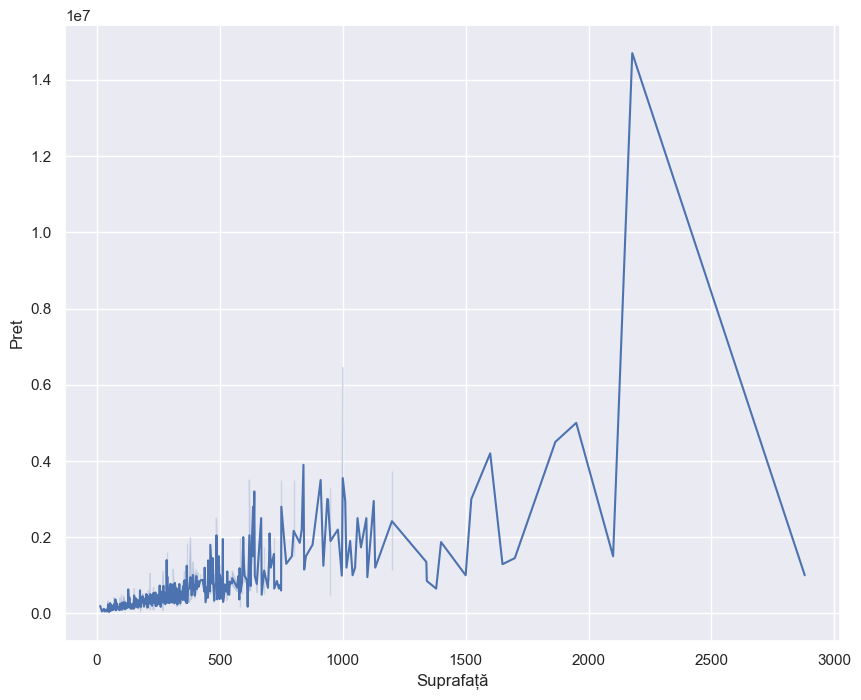

In [51]:
sns.lineplot(x="Suprafață", y="Pret", data=df)

<Axes: xlabel='Tip încălzire', ylabel='Pret'>

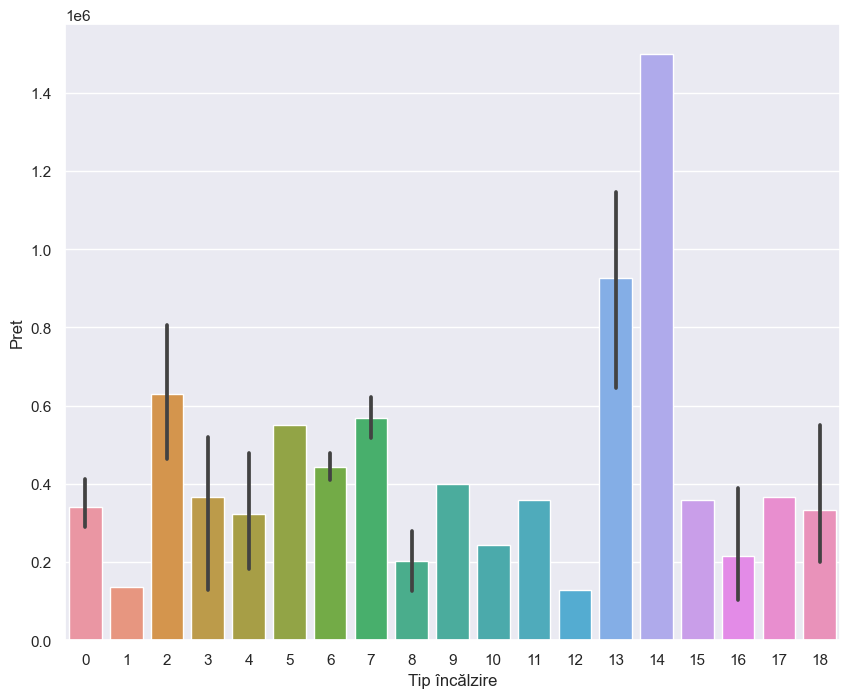

In [52]:
sns.barplot(x="Tip încălzire", y="Pret", data=df)

<Axes: xlabel='Suprafață teren (m²)', ylabel='Pret'>

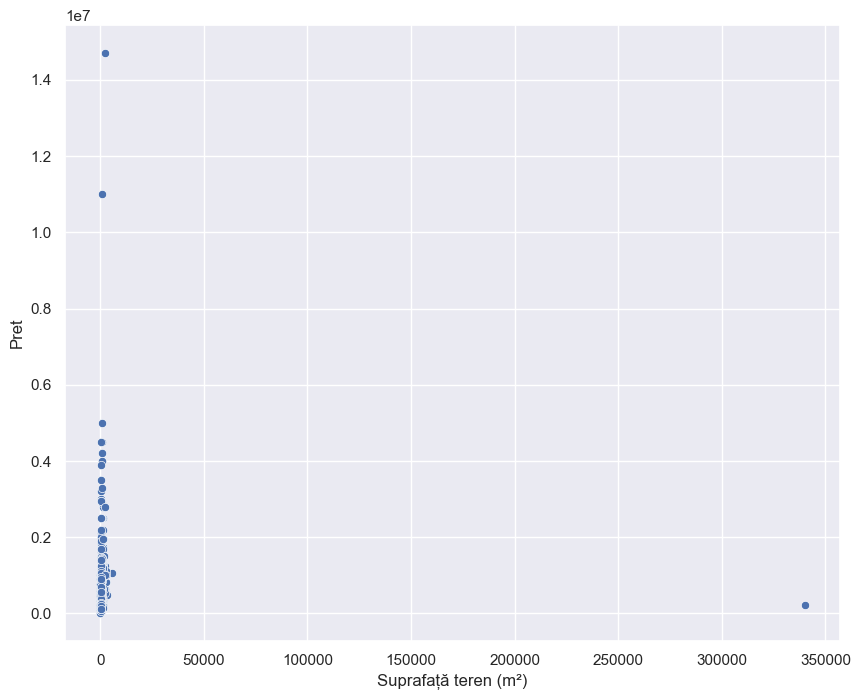

In [73]:
sns.scatterplot(x="Suprafață teren (m²)", y="Pret", data=df)

<Axes: xlabel='Stare', ylabel='Pret'>

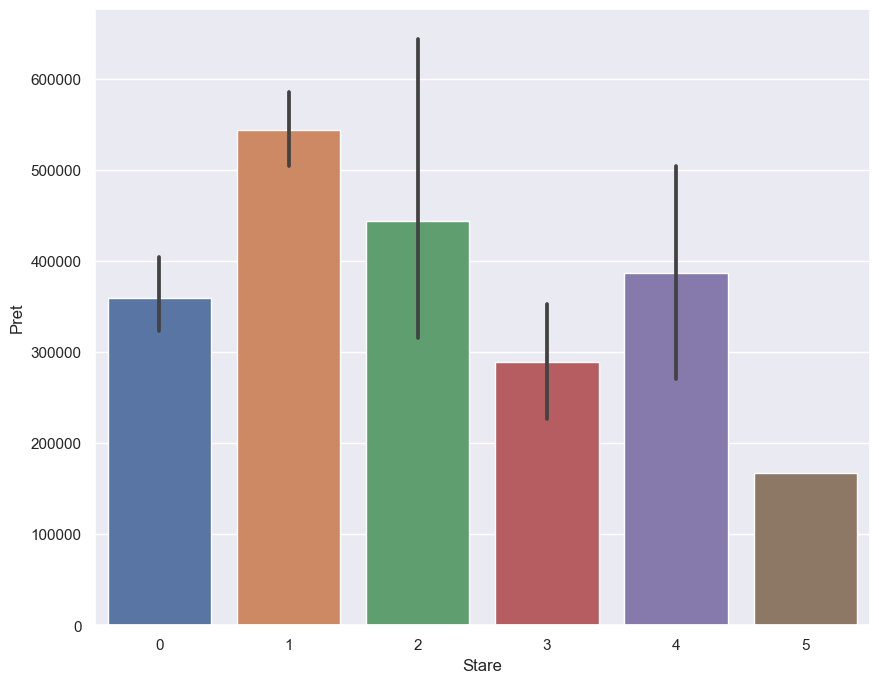

In [54]:
sns.barplot(x="Stare", y="Pret", data=df)

<Axes: xlabel='Tip clădire', ylabel='Pret'>

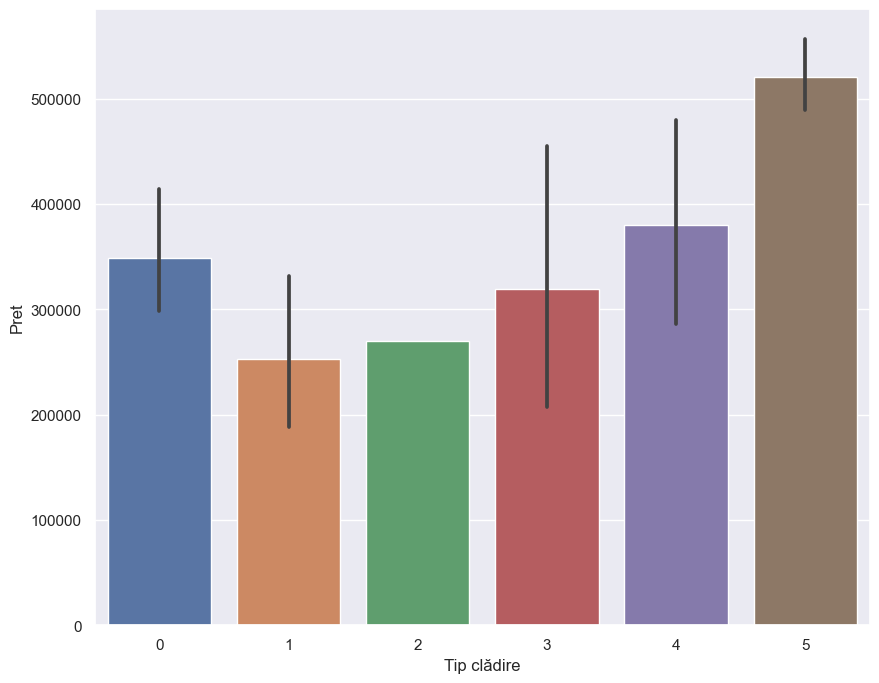

In [74]:
sns.barplot(x="Tip clădire", y="Pret", data=df)

<Axes: xlabel='Anul construcției', ylabel='Pret'>

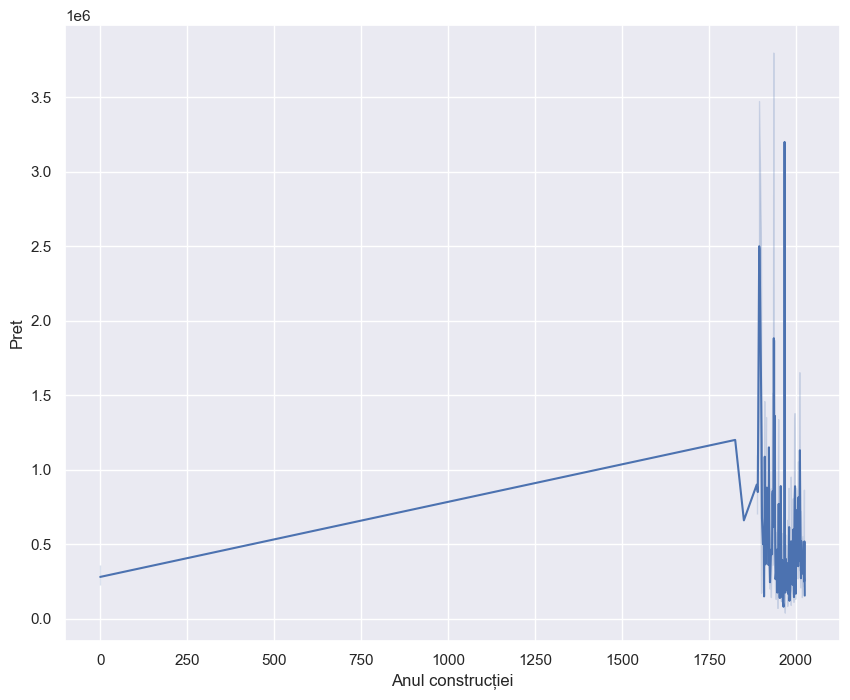

In [76]:
sns.lineplot(x="Anul construcției", y="Pret", data=df)

<Axes: xlabel='Numărul de camere', ylabel='Pret'>

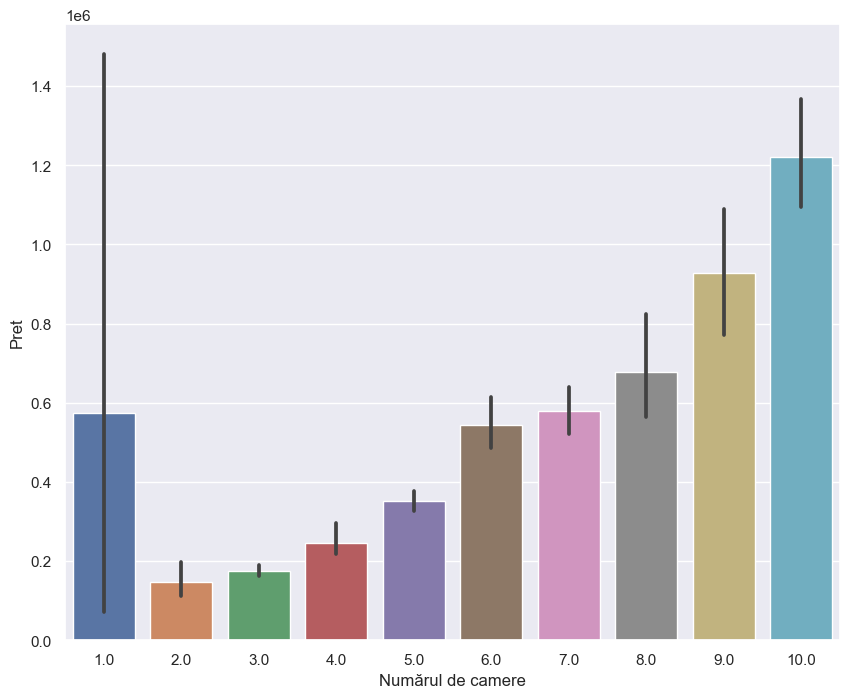

In [81]:
sns.barplot(x="Numărul de camere", y="Pret", data=df)

<Axes: xlabel='Garaj/loc de parcare', ylabel='Pret'>

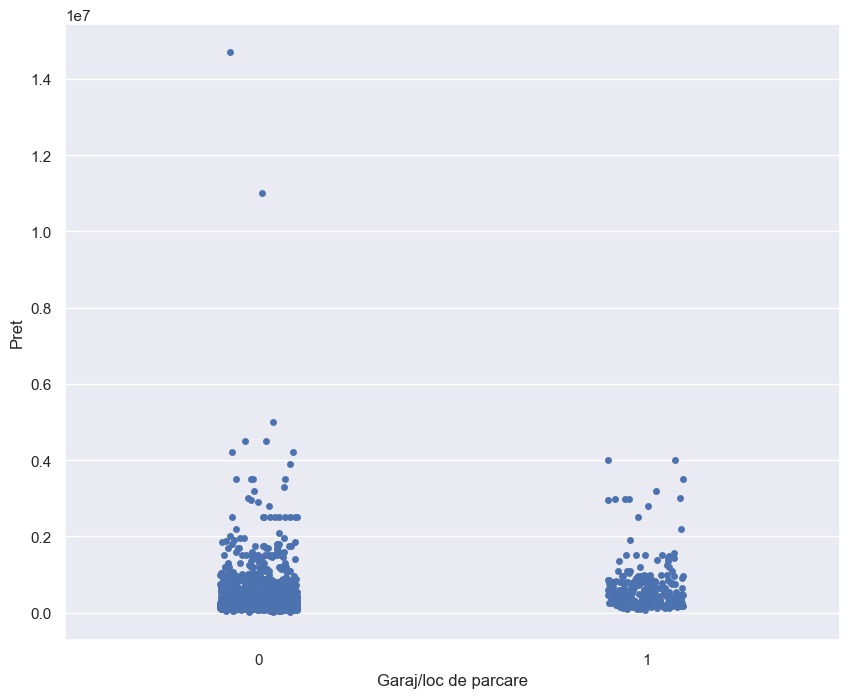

In [89]:
sns.stripplot(x="Garaj/loc de parcare", y="Pret", data=df)

<Axes: xlabel='Tip proprietate', ylabel='Pret'>

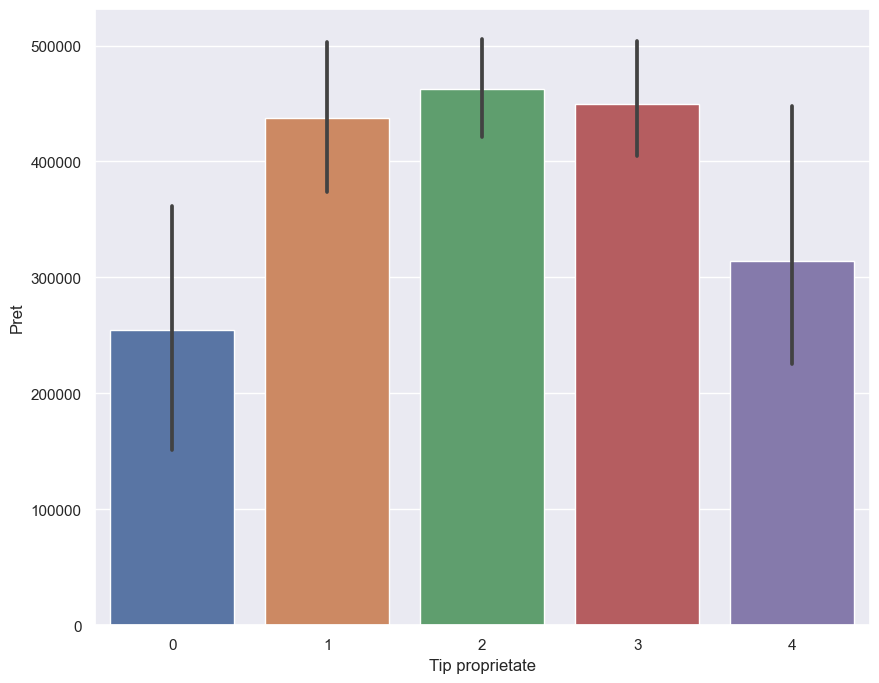

In [91]:
sns.barplot(x="Tip proprietate", y="Pret", data=df)

<Axes: xlabel='Material de construcție', ylabel='Pret'>

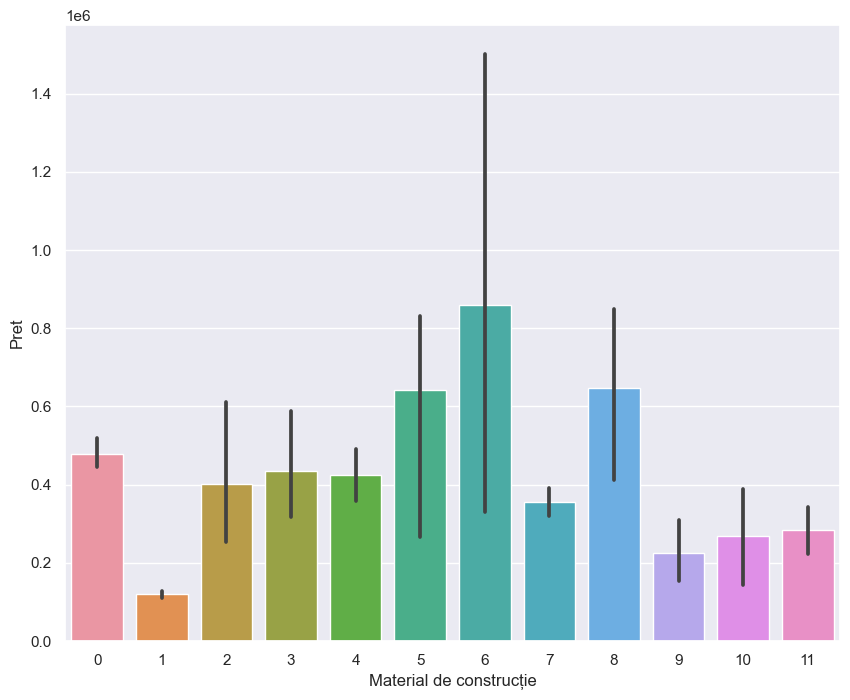

In [92]:
sns.barplot(x="Material de construcție", y="Pret", data=df)

<Axes: xlabel='Numar de etaje', ylabel='Pret'>

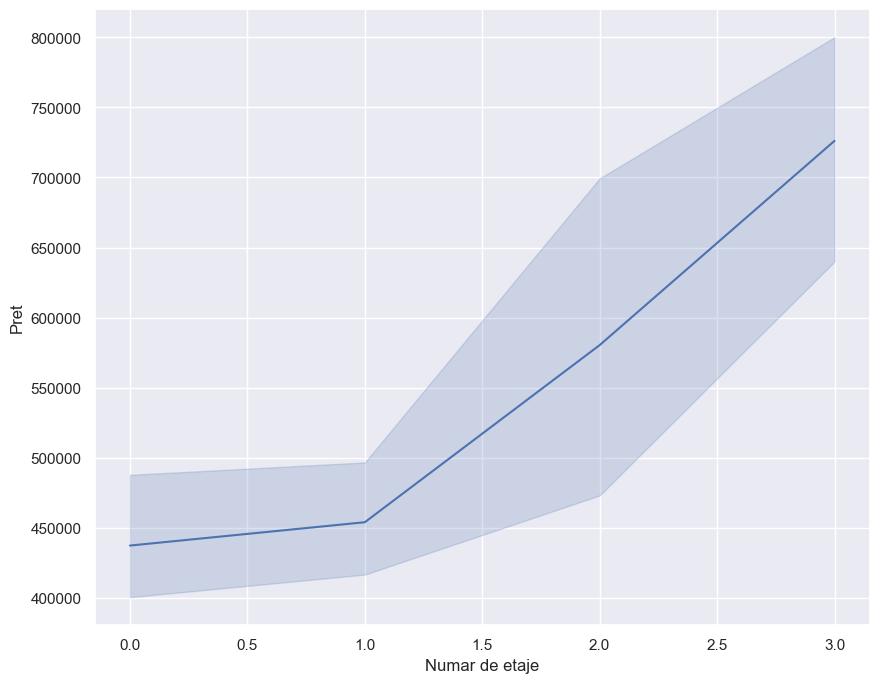

In [93]:
sns.lineplot(x="Numar de etaje", y="Pret", data=df)

<Axes: xlabel='Tip acoperis', ylabel='Pret'>

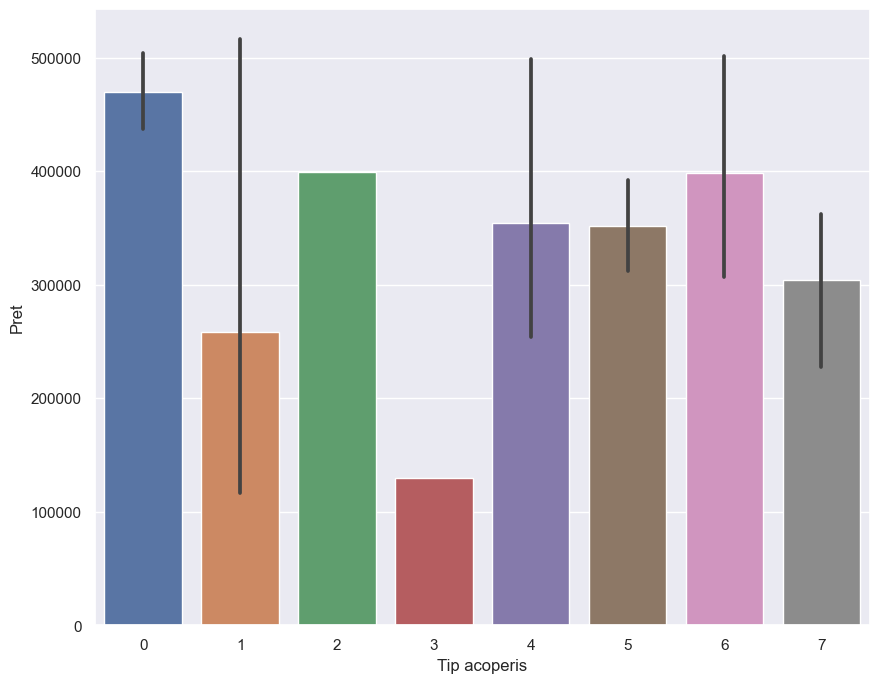

In [95]:
sns.barplot(x="Tip acoperis", y="Pret", data=df)

<Axes: xlabel='Acoperis', ylabel='Pret'>

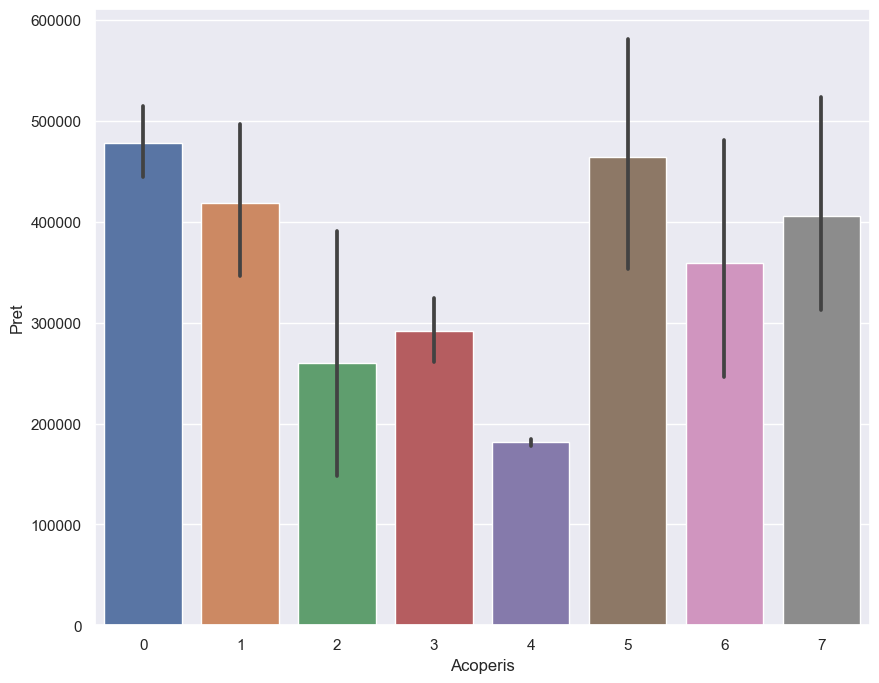

In [96]:
sns.barplot(x="Acoperis", y="Pret", data=df)

<Axes: xlabel='Tip mansardă', ylabel='Pret'>

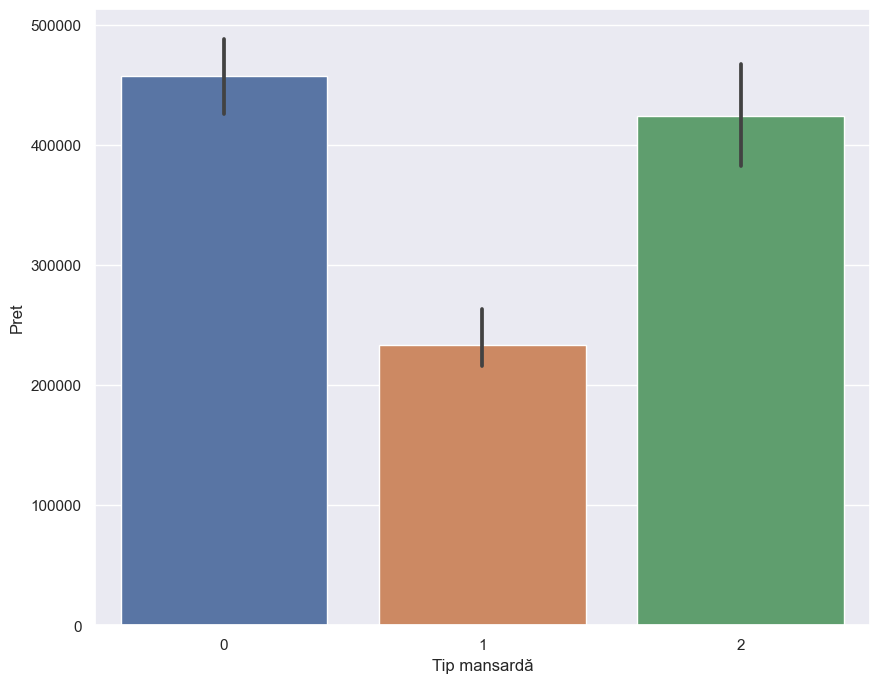

In [99]:
sns.barplot(x="Tip mansardă", y="Pret", data=df)

<Axes: xlabel='Tip acces', ylabel='Pret'>

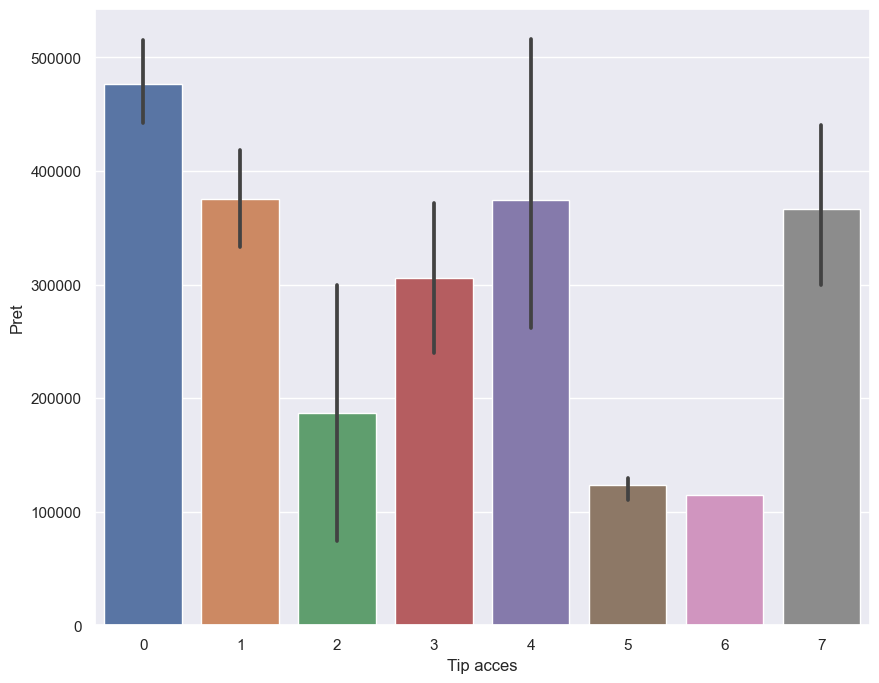

In [100]:
sns.barplot(x="Tip acces", y="Pret", data=df)

<Axes: xlabel='Locație', ylabel='Pret'>

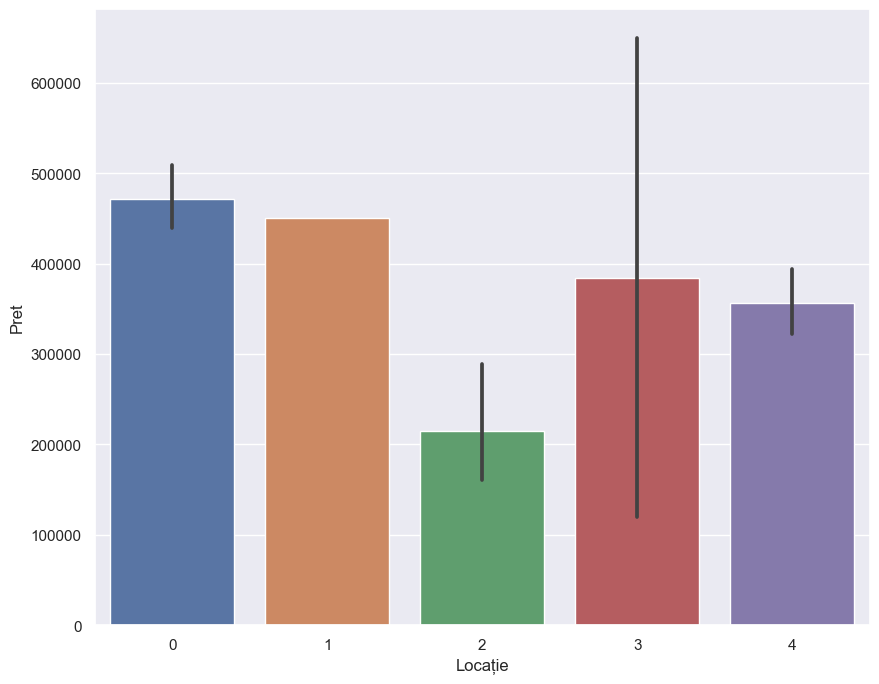

In [101]:
sns.barplot(x="Locație", y="Pret", data=df)

<Axes: xlabel='Aer condiționat', ylabel='Pret'>

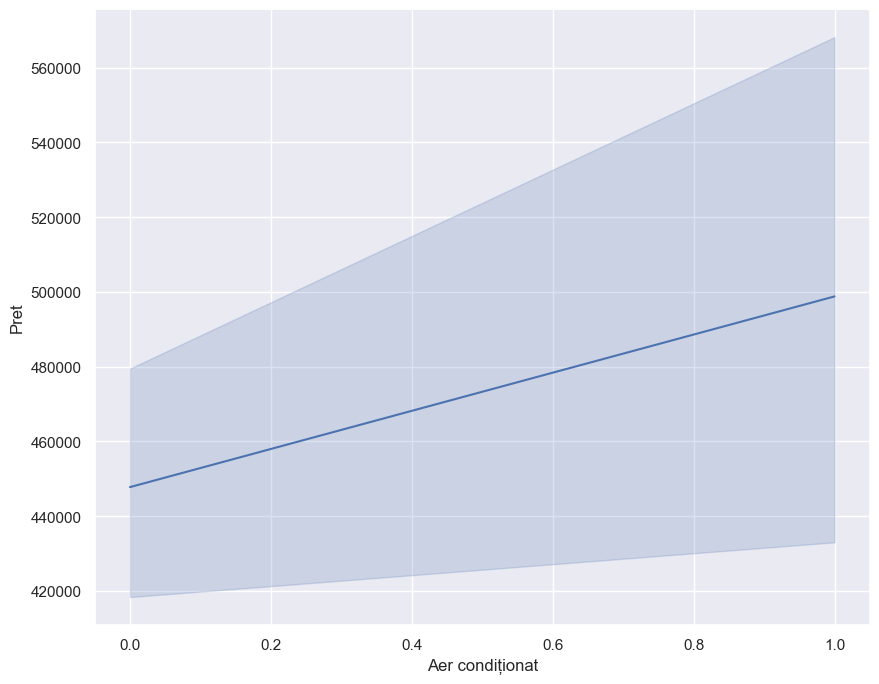

In [103]:
sns.lineplot(x="Aer condiționat", y="Pret", data=df)